# Image analysis with Gammapy

## Introduction

This tutorial shows how to make a significance image of the Crab nebula with Gammapy.

* Use the [gammapy.data.DataStore](http://docs.gammapy.org/en/latest/api/gammapy.data.DataStore.html)
  to load [gammapy.data.EventList](http://docs.gammapy.org/en/latest/api/gammapy.data.EventList.html) data.
* Fill the events in a [gammapy.image.SkyImage](http://docs.gammapy.org/en/latest/api/gammapy.image.SkyImage.html)
* Use the [gammapy.detect.KernelBackgroundEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.KernelBackgroundEstimator.html) to make a background and significance image.

## Setup

As usual, IPython notebooks start with some setup and Python imports

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from aplpy import FITSFigure

from astropy.coordinates import SkyCoord
from gammapy.data import DataStore
from gammapy.image import SkyImage
from gammapy.image import binary_disk, binary_ring
from gammapy.detect import KernelBackgroundEstimator as KBE
from gammapy.detect import KernelBackgroundEstimatorData as KBEData

## Data access

We will use the `DataStore` to access some example H.E.S.S. data (IRFs are real, events are simulated).

In [2]:
data_store = DataStore.from_dir('$GAMMAPY_EXTRA/datasets/hess-crab4-hd-hap-prod2/')

In [3]:
data_store.info()


Data store summary info:
name: noname

HDU index table:
BASE_DIR: /Users/deil/code/gammapy-extra/datasets/hess-crab4-hd-hap-prod2
Rows: 28
OBS_ID: 23523 -- 23592
HDU_TYPE: ['aeff', 'edisp', 'events', 'gti', 'psf']
HDU_CLASS: ['aeff_2d', 'edisp_2d', 'events', 'gti', 'psf_3gauss', 'psf_king', 'psf_table']

Observation table:
Number of observations: 4


In [4]:
data_store.hdu_table[:10][['OBS_ID', 'HDU_TYPE', 'HDU_CLASS', 'FILE_DIR', 'HDU_NAME']]

OBS_ID,HDU_TYPE,HDU_CLASS,FILE_DIR,HDU_NAME
int64,str6,str10,str26,str12
23523,gti,gti,run023400-023599/run023523,GTI
23523,events,events,run023400-023599/run023523,EVENTS
23523,aeff,aeff_2d,run023400-023599/run023523,AEFF_2D
23523,edisp,edisp_2d,run023400-023599/run023523,EDISP_2D
23523,psf,psf_3gauss,run023400-023599/run023523,PSF_2D_GAUSS
23523,psf,psf_king,run023400-023599/run023523,PSF_2D_KING
23523,psf,psf_table,run023400-023599/run023523,PSF_2D_TABLE
23526,gti,gti,run023400-023599/run023526,GTI
23526,events,events,run023400-023599/run023526,EVENTS


## Counts image

Let's make a counts image using the `SkyMap` class.

In [5]:
source_pos = SkyCoord(83.633083, 22.0145, unit='deg')
# If you have internet access, you could also use this to define the `source_pos`:
# source_pos = SkyCoord.from_name('crab')
print(source_pos)

<SkyCoord (ICRS): (ra, dec) in deg
    (83.633083, 22.0145)>


In [6]:
ref_image = SkyImage.empty(
    nxpix=400, nypix=400, binsz=0.02,
    xref=source_pos.ra.deg, yref=source_pos.dec.deg,
    coordsys='CEL', proj='TAN',
)

In [7]:
# Make a counts image for a single observation
events = data_store.obs(obs_id=23523).events
counts_image = SkyImage.empty_like(ref_image)
counts_image.fill_events(events)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.000e+00 [aplpy.core]


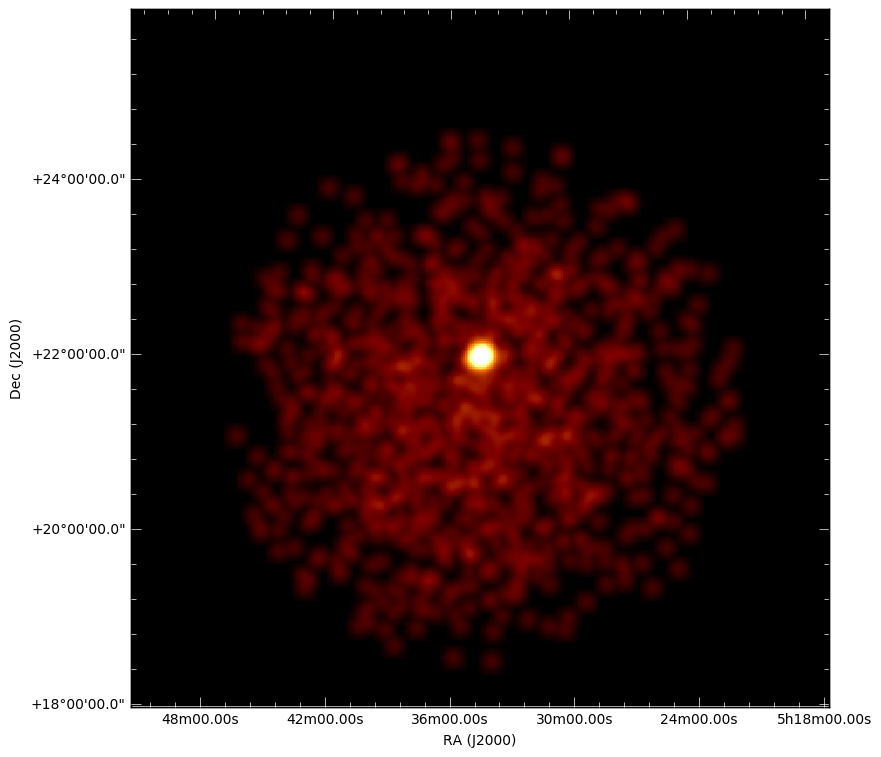

In [8]:
# This is one way to plot a sky image
fig = FITSFigure(counts_image.to_image_hdu())
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')

In [9]:
# Making a counts image for multiple observations is a bit inconvenient at the moment
# we'll make that better soon.
# For now, you can do it like this:
obs_ids = [23523, 23526]
counts_image2 = SkyImage.empty_like(ref_image)
for obs_id in obs_ids:
    events = data_store.obs(obs_id=obs_id).events
    counts_image2.fill_events(events)

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.000e+00 [aplpy.core]


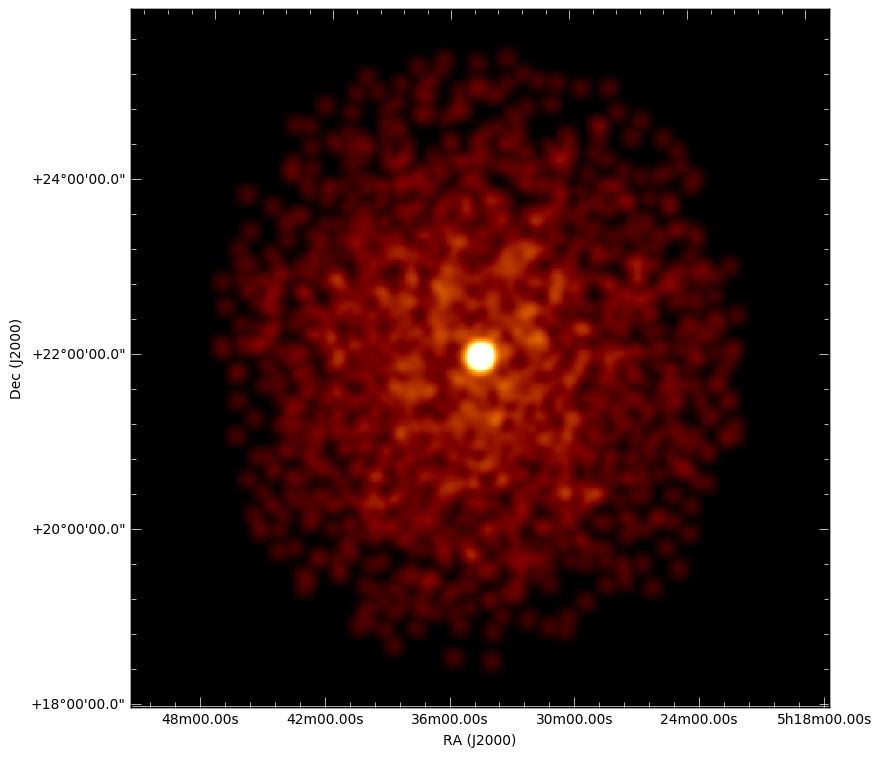

In [10]:
# Let's have a look
fig = FITSFigure(counts_image2.to_image_hdu())
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')

# Background modeling

In Gammapy a few different methods to estimate the background are available.

Here we'll use the [gammapy.detect.KernelBackgroundEstimator](http://docs.gammapy.org/en/latest/api/gammapy.detect.KernelBackgroundEstimator.html) to make a background image
and the make a significance image.

In [11]:
# To use the `KernelBackgroundEstimator` you first have to set
# up a source and background kernel and put the counts image input
# into a container `KernelBackgroundEstimatorData` class.
images = KBEData(counts_image2.data, header=counts_image2.wcs.to_header())

source_kernel = binary_disk(5)
background_kernel = binary_ring(20, 30)

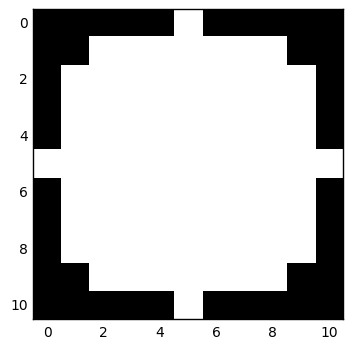

In [12]:
plt.imshow(source_kernel, interpolation='nearest', cmap='gray')

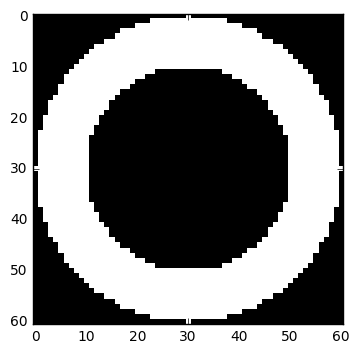

In [13]:
plt.imshow(background_kernel, interpolation='nearest', cmap='gray')

In [14]:
kbe = KBE(
    images=images,
    source_kernel=source_kernel,
    background_kernel=background_kernel,
    significance_threshold=5,
    mask_dilation_radius=3,
)
# This takes about 10 seconds on my machine
result = kbe.run()

/Users/deil/Library/Python/3.5/lib/python/site-packages/gammapy-0.5.dev3458-py3.5-macosx-10.11-x86_64.egg/gammapy/stats/poisson.py:254: RuntimeWarning: invalid value encountered in sqrt
  term_b = sqrt(n_on * log(n_on / mu_bkg) - n_on + mu_bkg)


/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


INFO: Auto-setting vmin to  0.000e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.038e-01 [aplpy.core]


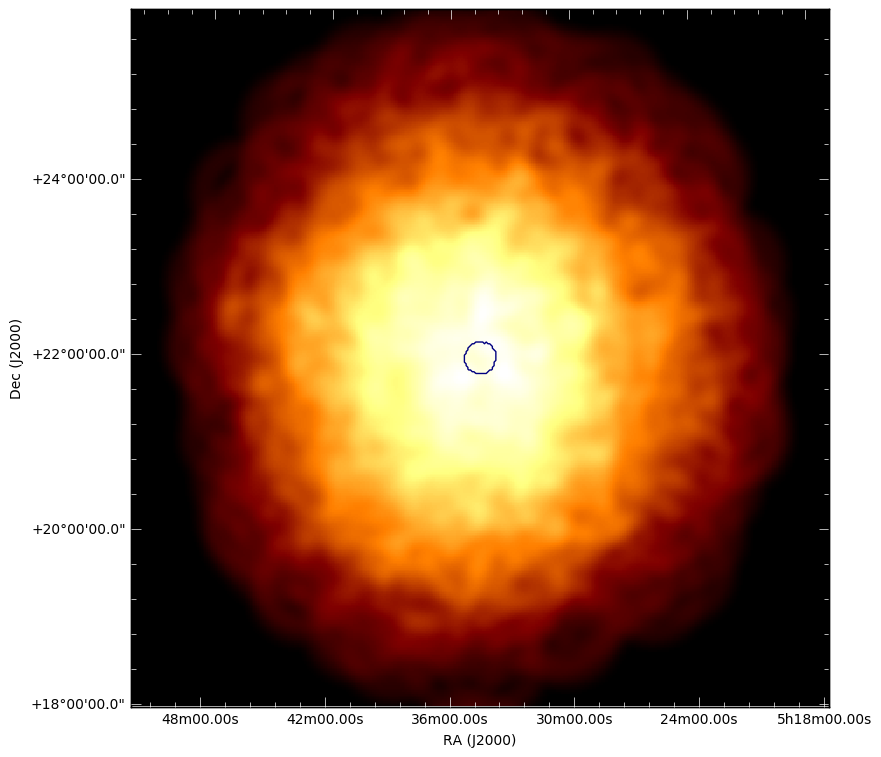

In [15]:
# Let's have a look at the background image and the exclusion mask
fig = FITSFigure(kbe.background_image_hdu)
fig.show_colorscale(smooth=3, stretch='sqrt', cmap='afmhot')
fig.show_contour(kbe.mask_image_hdu, levels=[0.5])

/opt/local/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/matplotlib/artist.py:224: MatplotlibDeprecationWarning: get_axes has been deprecated in mpl 1.5, please use the
axes property.  A removal date has not been set.
  stacklevel=1)


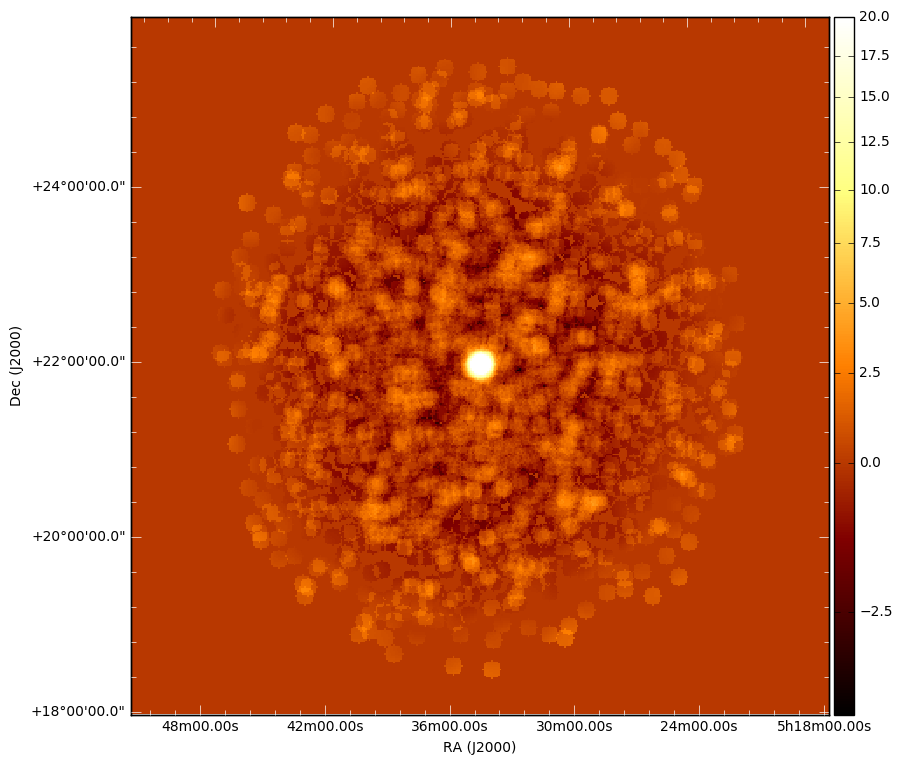

In [16]:
# Finally ... tada ... the Crab on a significance image!
fig = FITSFigure(kbe.significance_image_hdu)
fig.show_colorscale(vmin=-3, vmax=20, stretch='sqrt', cmap='afmhot')
fig.show_colorbar()

## Exercises

- Compute the counts, excess, background and significance at the Crab nebula position.
- Make an energy distribution of the events at the Crab nebula position.

## What next?

TODO: summarise

TODO: give links what to do next.